# Week 5 Final  Project
This assignment is using a dataset from Kaggle  with bank customer information on credit card profiles and bank interaction volume.  In the scenario, the bank is trying to determine if it can customize service delivery and marketing processes and campaigns based on customer segments.  They have asked us to analyze the data and determine if there are segments that behave differently and provide some high level recommendations for their treatment.

We will use different clustering techiniques to identify segments within the customer data.  This is a typical use case where unsupervised learning can be effective as it searches for signals and clusters the data, in this case customers into segments.

A copy of this notebook and the data used can be found in Github at  https://github.com/mjn82/UCOLORADO


## Data  Desciption
The following data is provided within Kaggle.  I will be providing links to a github repository with both the notebook and data.

The data includes bank activity and credit card information for a random sample of the bank's customers.  This includes interaction online, call center and in person as well as credit limits and number of credit cards.  

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)


In [ ]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# Supressing warnings
import warnings

warnings.filterwarnings("ignore")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [ ]:
# upload data
data = pd.read_excel("Credit Card Customer Data.xlsx", header=0, names=None)

<IPython.core.display.Javascript object>

In [ ]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

The dataframe has 660 rows and 7 columns

In [ ]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [ ]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

In [ ]:
# dropping the Sl_No column and Customer Key as they not provide any information
df.drop("Sl_No", axis=1, inplace=True)
df.drop("Customer Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [ ]:
# Reviewing the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


<IPython.core.display.Javascript object>

All columns are integers

In [ ]:
# Checking for duplicate observations
df.duplicated().sum()

11

<IPython.core.display.Javascript object>

There are 11 duplicate observations. We will remove them from the data.

In [ ]:
df = df[(~df.duplicated())].copy()  # removes duplicates

<IPython.core.display.Javascript object>

In [ ]:
# reviewing the data summary
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,649.000000,649.000000,649.000000,649.000000,649.000000
mean,34878.274268,4.708783,2.397535,2.624037,3.590139
std,37813.736638,2.173763,1.625148,2.952888,2.877911
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,11000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,49000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


<IPython.core.display.Javascript object>

Observations

- The average credit limit is 34878 and the IQR is from 11000 to 49000
- The average number of credit cards is 4.7 with an IQR of 3 to 6
- Customers on average visited the bank 2.4 times with some customers never visiting and none visiting more than 5 times
- Customers on average visited online 2.6 times with some customers never visiting online and 75% visiting 4 or less times
- Customers on average called 3.6 times with some customers never calling online and 75% visiting 5 or less times

In [ ]:
# checking missing values
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

There are no missing values

# EDA

### Univariate Analysis

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

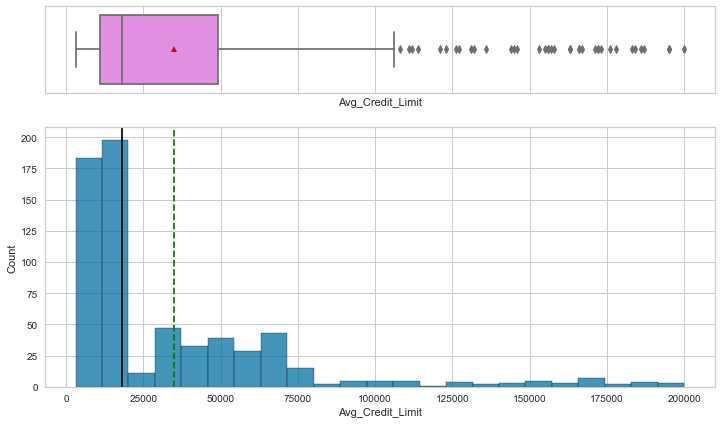

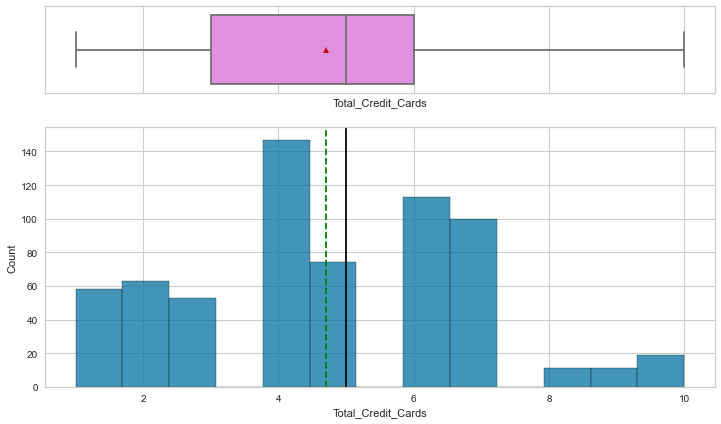

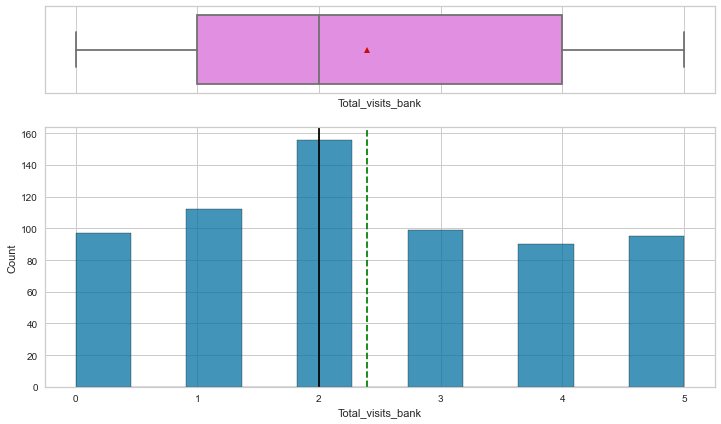

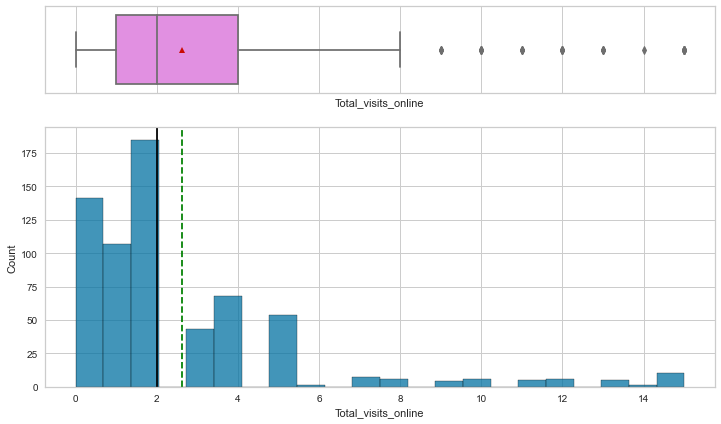

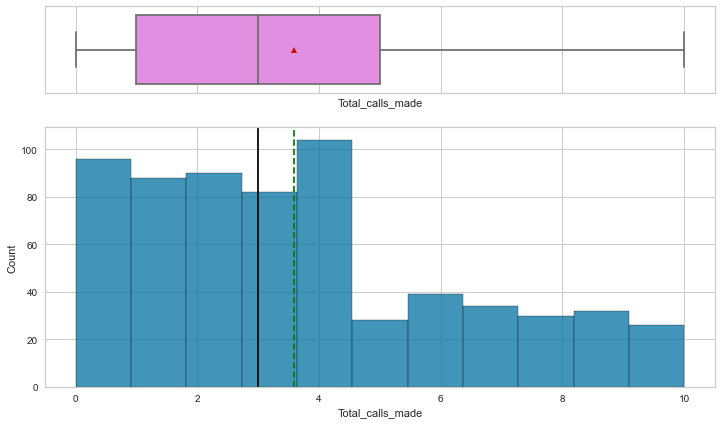

<IPython.core.display.Javascript object>

In [ ]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

Observations

- Average Credit Limit is right skewed with a good number of credit limit outliers
- Number of credit cards is a somewhat normal distribution in the range of 1 to ten cards
- Number of bank visits is a  normal distribution in the range of 1 to 5 visits
- Number of online visits is a right skewed with the mean just below 3, no outliers but a number of vistors the above the IQR
- Number of calls is  is a right skewed with the mean around 3, no outliers but a number with calls  the above the IQR


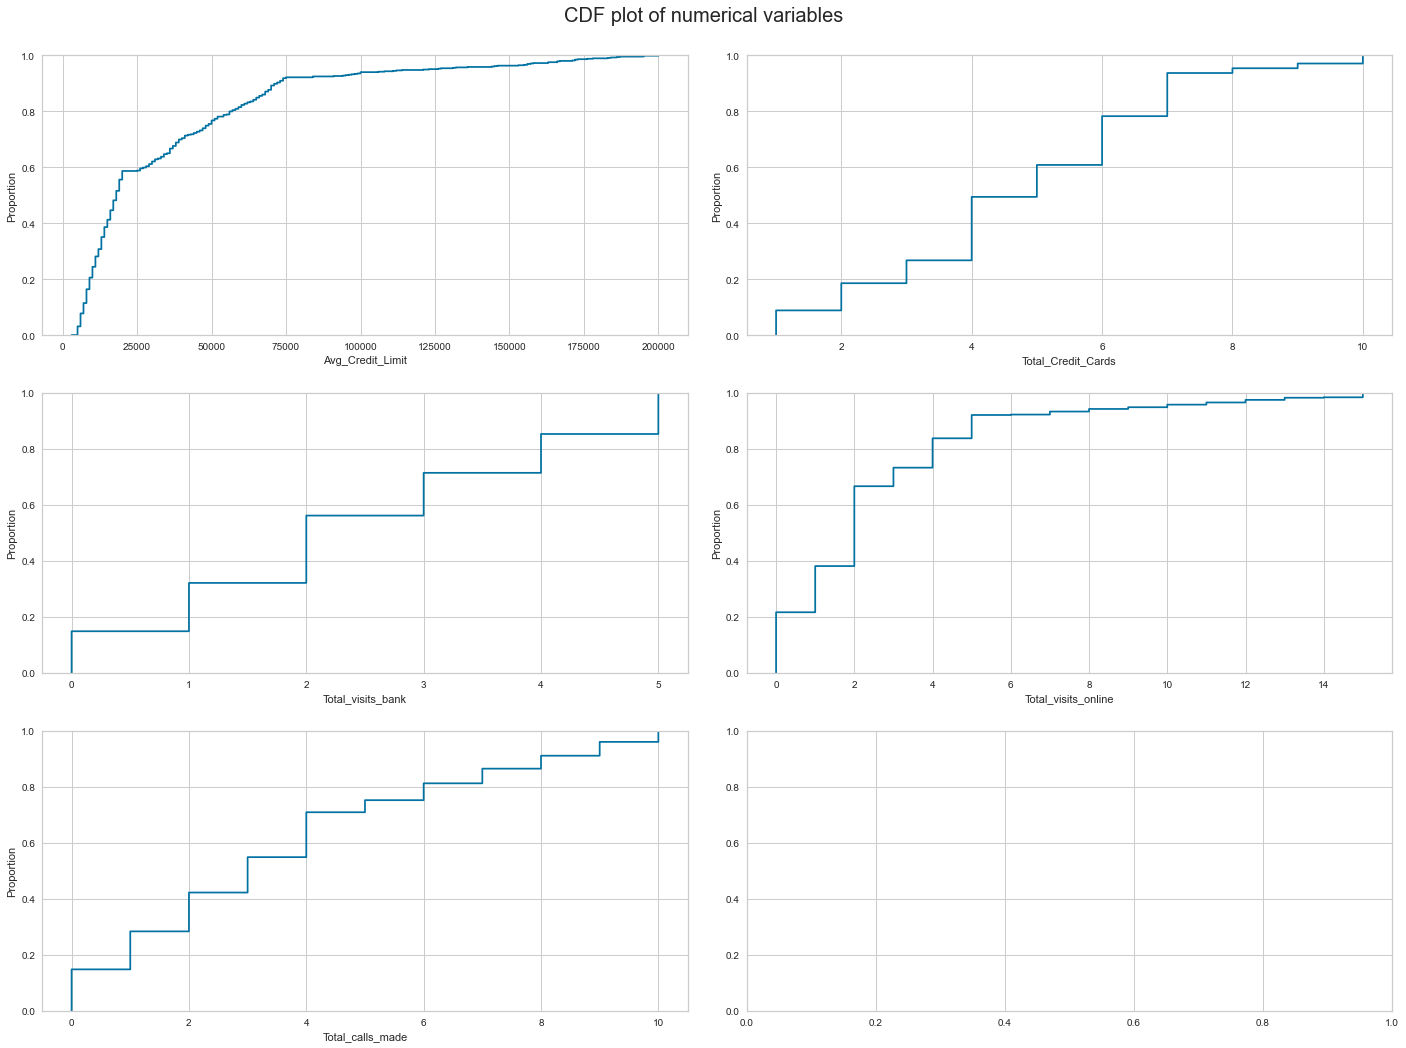

<IPython.core.display.Javascript object>

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

Observations

- 60% of customers have a credit limit below 25000 and 8% above 75000
- 78% of customers have a 6 or less credit cards
- 25% of customers visited the bank more than 4 times
- Around 2/3rds of customers visited online 2 times or less and 8% visited 6 times or more
- Around 2/3rds of customers called 4 times or less and 20% called 5 to 10 times

## Bivariate Analysis

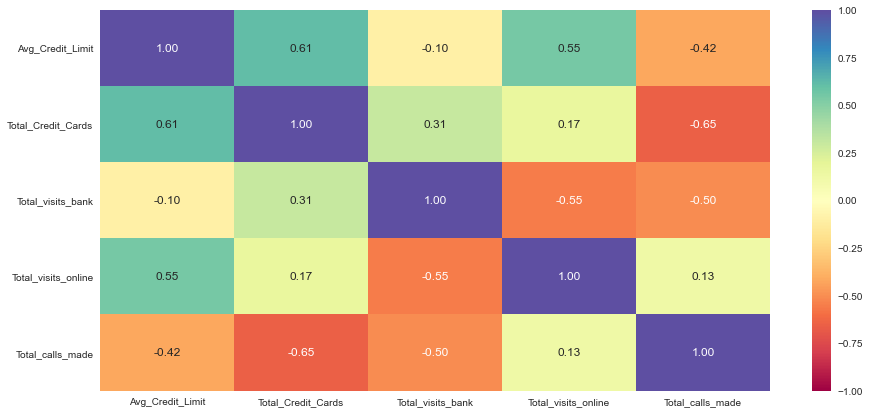

<IPython.core.display.Javascript object>

In [ ]:
# Using a heatmap to check for correlations
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Observations
- There is a correlation between average credit limit and number of cards
- There is a negative correlation betwwen online visits as well as calls made against visits to the banks
- There is a negative correlation between total credit cards and calls
- There is a correlation between average credit limit and visits online

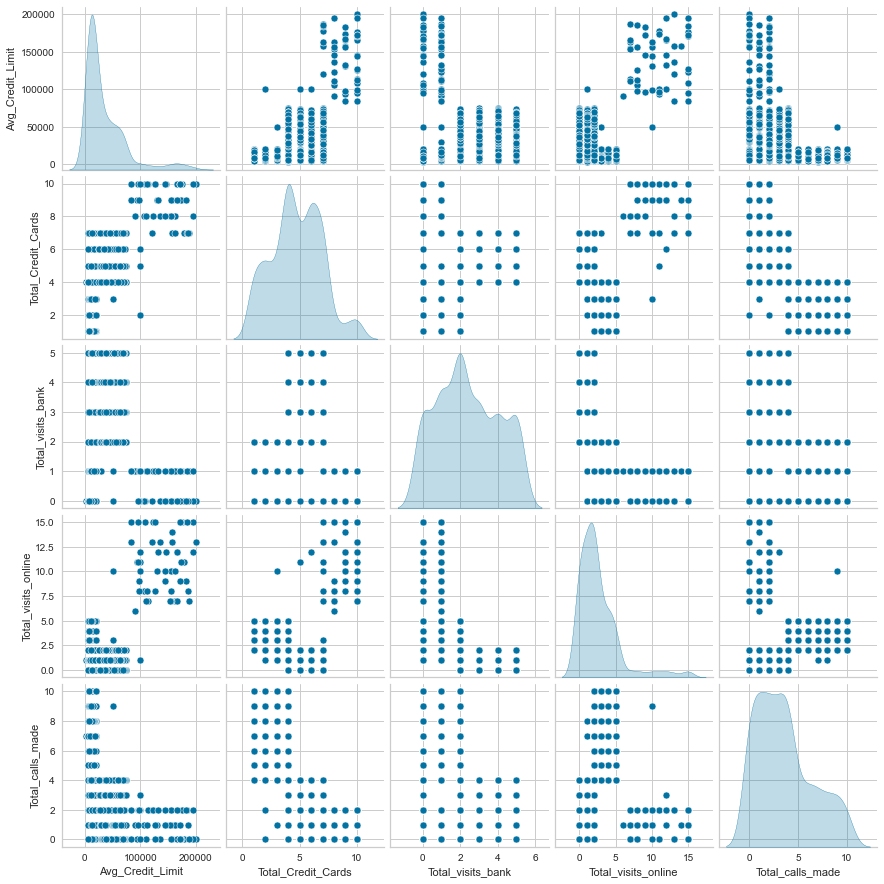

<IPython.core.display.Javascript object>

In [ ]:
#  running a pairplot as well for correlation and adding a kernal density line to show possible groupings to figure out K
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

Observations
- There are two to three humps in total credit cards distribution-  
- There may be two humps in average credit limit for moderate limits and for high limits
- There may be more than one grouping for those who visited the bank
- I will visit these kdes when determining my K for K Means Clustering

## Data Preprocessing

Steps
- Remove Null Values -  Checked earlier and no null values present so this step will be skipped
- Remove Duplicates  Prior to analyzing data I already checked for duplicate rows and removed 11 rows. I used the below steps
-- step a # Checking for duplicate observations df.duplicated().sum()
-- step b # removes duplicates df = df[(~df.duplicated())].copy()
- Feature Engineering  I am creating a Total_Contacts column to reflect the total number of contacts for each customer
- Remove Outliers  Will treat outliers by clipping in the Avg_Credit_Limit and Total_Visits_Online columns
- Scaling  I will use standard scaler to scale data as required prior to clustering

In [ ]:
# Summing the three contact columns into a new column
# Add two columns to make a new column
df["Total_contacts"] = (
    df["Total_visits_bank"] + df["Total_visits_online"] + df["Total_calls_made"]
)
print("Updated DataFrame:")
print(df)

Updated DataFrame:
     Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  Total_contacts  
0                      1                 0               2  
1                     10                 9              19  
2                      3     

<IPython.core.display.Javascript object>

In [ ]:
# function yo  treat outliers by flooring and capping
def treat_outliers(df, col):
    """
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR
    df[col] = np.clip(
        df[col], Lower_Whisker, Upper_Whisker
    )  # all the values samller than Lower_Whisker will be assigned value of Lower_whisker
    # and all the values above upper_whishker will be assigned value of upper_Whisker
    return df


def treat_outliers_all(df, col_list):
    """
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

<IPython.core.display.Javascript object>

In [ ]:
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
df = treat_outliers_all(df, numerical_col)

<IPython.core.display.Javascript object>

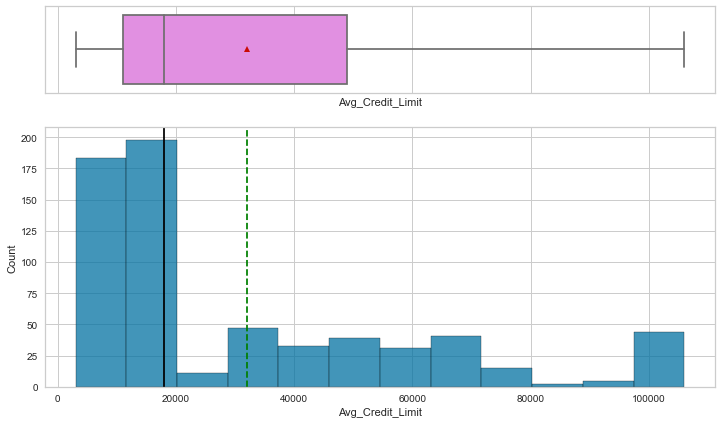

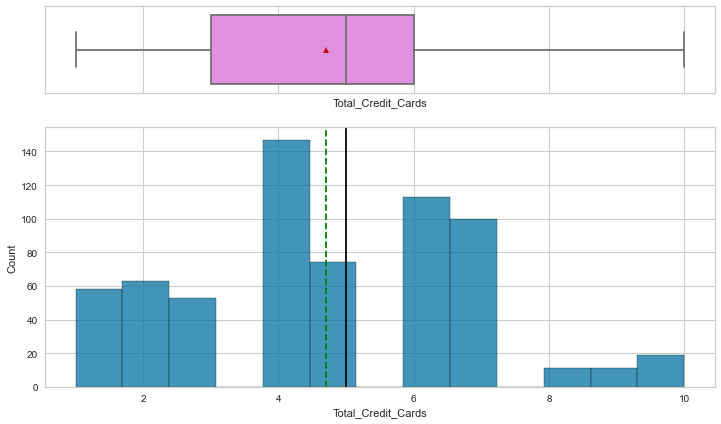

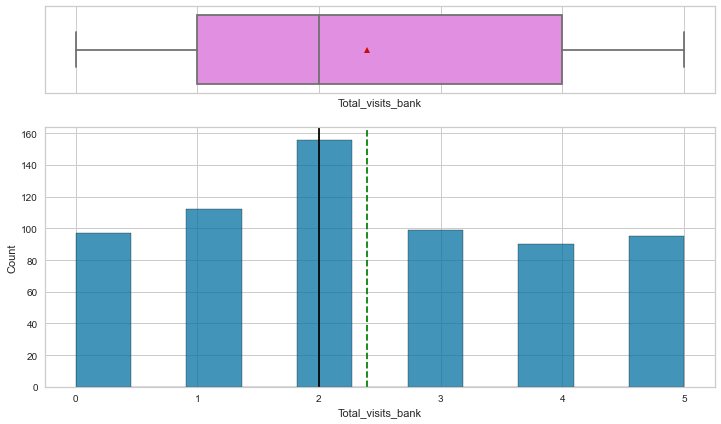

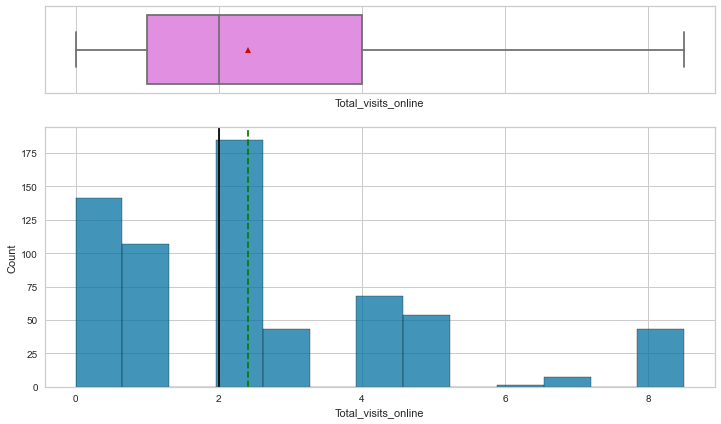

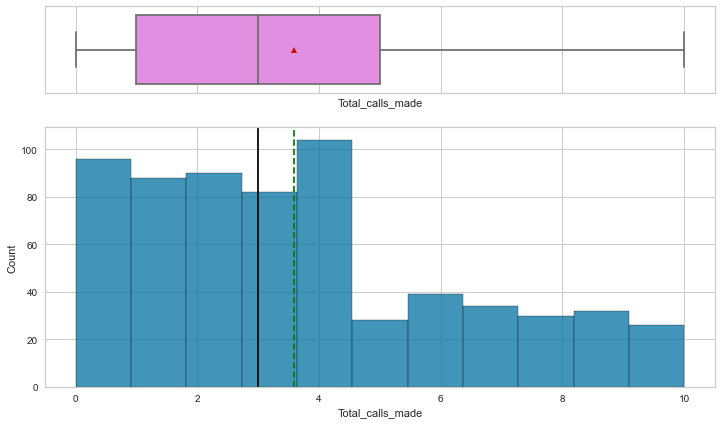

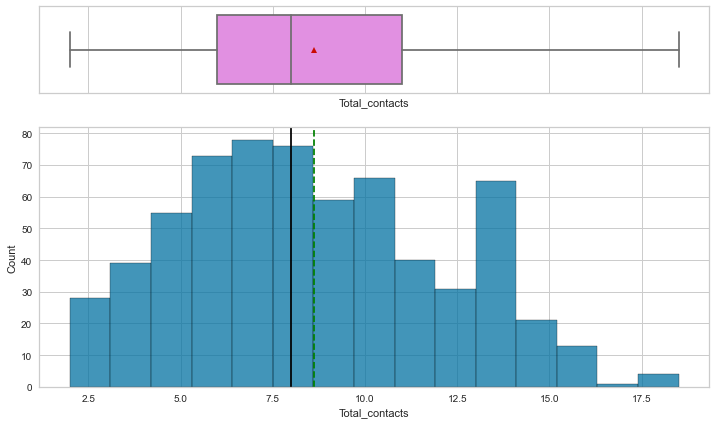

<IPython.core.display.Javascript object>

In [ ]:
# Running box plot to confirm that outliers have been treated
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

- Avg_Credit_limit and Total_Visits_Online no longer have outliers
- New Column Total_contacts has a mean of just under 8 and a normal distribution

In [ ]:
# variables used for clustering
num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made',
 'Total_contacts']

<IPython.core.display.Javascript object>

In [ ]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [ ]:
#  creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

In [ ]:
subset_scaled_df.sample(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_contacts
11,-0.660527,-0.786701,-1.476410,-0.181907,1.185753,0.113707
279,-0.904115,0.594459,0.371000,-0.623244,-0.900701,-1.055341
486,0.592217,0.134072,0.371000,-0.181907,-0.205216,-0.178555
9,-1.008511,-0.326314,-1.476410,-0.623244,1.185753,-0.178555
437,1.322983,0.134072,0.986803,-1.064581,-0.552958,-0.763079
269,-0.521333,0.594459,-0.244803,-0.181907,0.142526,-0.178555
573,0.070240,0.594459,0.986803,-0.623244,-0.205216,-0.178555
382,-0.730123,-0.326314,-0.244803,-1.064581,0.142526,-0.763079
599,0.244232,1.054846,-0.244803,-0.623244,-1.248443,-1.639865
232,-0.660527,1.054846,0.986803,-1.064581,-1.248443,-1.347603


<IPython.core.display.Javascript object>

# K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.2804165348588836
Number of Clusters: 2 	Average Distortion: 1.6568611057040448
Number of Clusters: 3 	Average Distortion: 1.3357229674382314
Number of Clusters: 4 	Average Distortion: 1.228267378667603
Number of Clusters: 5 	Average Distortion: 1.142621886240667
Number of Clusters: 6 	Average Distortion: 1.0694466857183353
Number of Clusters: 7 	Average Distortion: 1.0343962523854946
Number of Clusters: 8 	Average Distortion: 1.001157586905629


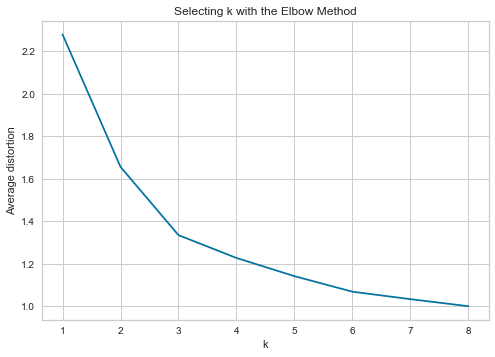

<IPython.core.display.Javascript object>

In [ ]:
#  This function will help us determine an optimal Kby trying a range of Ks  when fitting to the scaled dataframe
# and providing silhouette scores and a graph to visually find the elbow
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

**Appropriate value for k seems to be 3**

## Getting Silhouette scores

For n_clusters = 2, the silhouette score is 0.4148198472437739)
For n_clusters = 3, the silhouette score is 0.5092544296852327)
For n_clusters = 4, the silhouette score is 0.35166430070474475)
For n_clusters = 5, the silhouette score is 0.2839441223146297)
For n_clusters = 6, the silhouette score is 0.2845855214846364)
For n_clusters = 7, the silhouette score is 0.27083940608702944)
For n_clusters = 8, the silhouette score is 0.2682152422670698)
For n_clusters = 9, the silhouette score is 0.26639755717666885)


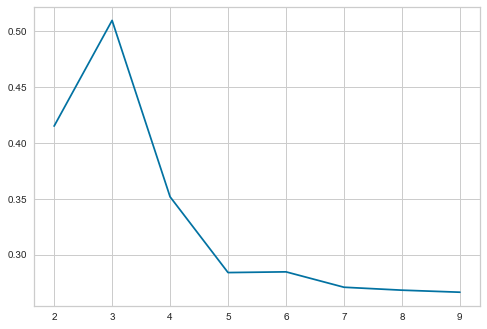

<IPython.core.display.Javascript object>

In [ ]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

**Silhouette score for 3 is the highest and confirms my previous elbow recommendation of 3 Clusters ,  I will assign 3 to K**

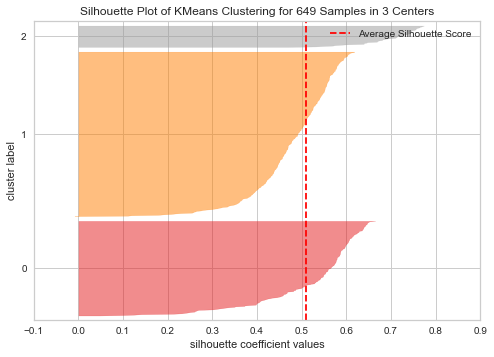

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [ ]:
# Using 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [ ]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

In [ ]:
cluster_profile_Kmeans = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [ ]:
cluster_profile_Kmeans["count_in_each_segments"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [ ]:
# let's display cluster profiles
cluster_profile_Kmeans.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_contacts,count_in_each_segments
K_means_segments,,,,,,,
0,12251.141553,2.401826,0.945205,3.573059,6.931507,11.454338,219
1,33950.000000,5.507895,3.471053,0.984211,1.994737,6.450000,380
2,103440.000000,8.740000,0.600000,8.180000,1.080000,12.580000,50


<IPython.core.display.Javascript object>

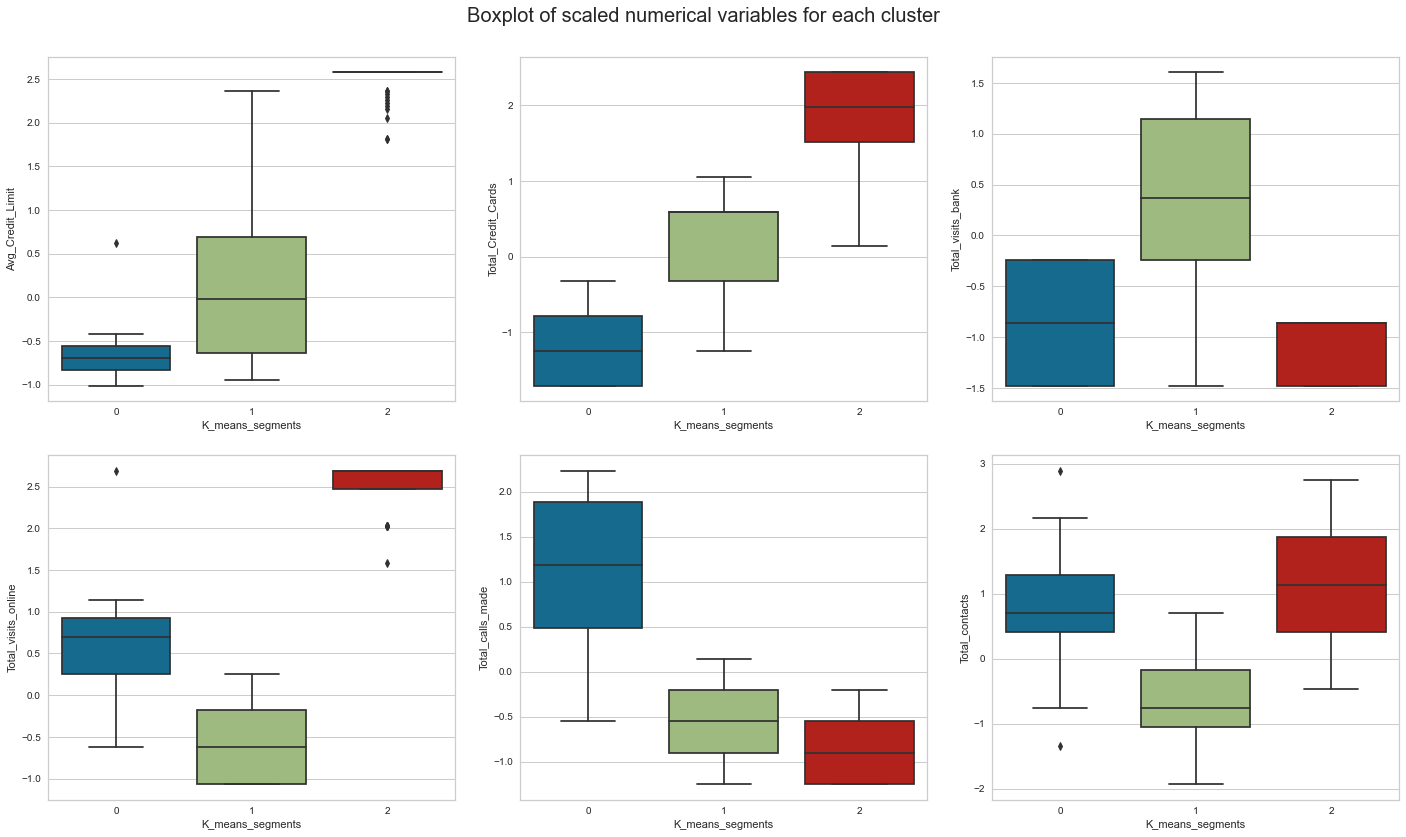

<IPython.core.display.Javascript object>

In [ ]:
# Creating boxplots of the numerical columns in the scaled dataframe by cluster
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(2):
    sns.boxplot(
        ax=axes[ii][0],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)

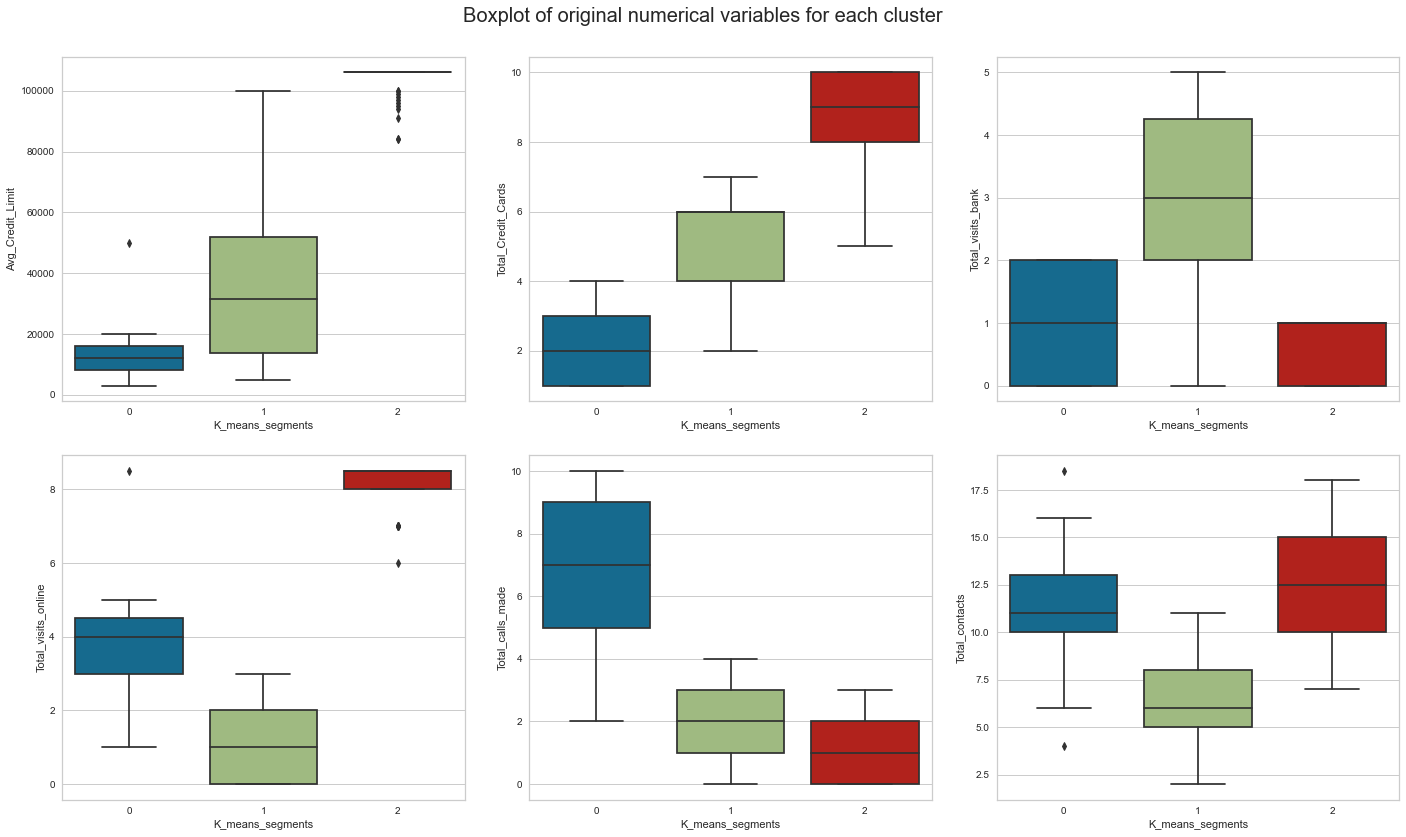

<IPython.core.display.Javascript object>

In [ ]:
# Creating boxplots of the numerical columns in the original dataframe by cluster
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(2):
    sns.boxplot(
        ax=axes[ii][0],
        y=df[num_col[counter]],
        x=df["K_means_segments"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1],
        y=df[num_col[counter]],
        x=df["K_means_segments"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2],
        y=df[num_col[counter]],
        x=df["K_means_segments"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)

Observations
- **Cluster 0**:
  - Low average credit limits, nearly all below 20,000
  - Few cards held, on average 2 cards but no more than 4
  - Calls the bank often. on average 7 times and also uses online moderately
  - Contacts the bank on average 11 times , primarily by phone
- **Cluster 1**:
  - Moderate credit limits, the average is above 30,000 but ranges up to 100,000
  - They visit the bank most often, 75% visit at least 3 times.  On avaerage they only use online once and call twice
  - Contacts the bank mleast frequently, half as frequently as other customers, on average 6 times
- **Cluster 2**:
  - High average credit limits, None below 80,000
  - 5 to 10 credit cards
  - Frequently make online contact, 6 to 9 contacts per customer
  - Contacts the bank most frequently with a quarter of the group contacting 15 times
  

In [ ]:
# Creating function to determine cophenetic correlation for varied distance and linkage paramaters
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8260065915075747.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8071102026625019.
Cophenetic correlation for Euclidean distance and average linkage is 0.8906948077535922.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8704134023433066.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8771802300632312.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7152954492238442.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8885705840779242.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.799588282610462.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8712961418376337.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5155720471857556.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7491306702626634.
Cophenetic cor

<IPython.core.display.Javascript object>

In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8906948077535922, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

Apply Hierarchical Clustering with different linkage methods - Plot dendrograms for each linkage method - Figure out the appropriate number of clusters 10 Compare clusters from K-means and Hierarchical Clustering and perform cluster profiling

In [ ]:
# Creating function to check cophenetic correaltion based on Euclidian distance for a broader list of linkages
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8260065915075747.
Cophenetic correlation for complete linkage is 0.8071102026625019.
Cophenetic correlation for average linkage is 0.8906948077535922.
Cophenetic correlation for centroid linkage is 0.8859732669687681.
Cophenetic correlation for ward linkage is 0.7818635216729553.
Cophenetic correlation for weighted linkage is 0.8704134023433066.


<IPython.core.display.Javascript object>

In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8906948077535922, which is obtained with average linkage.


<IPython.core.display.Javascript object>

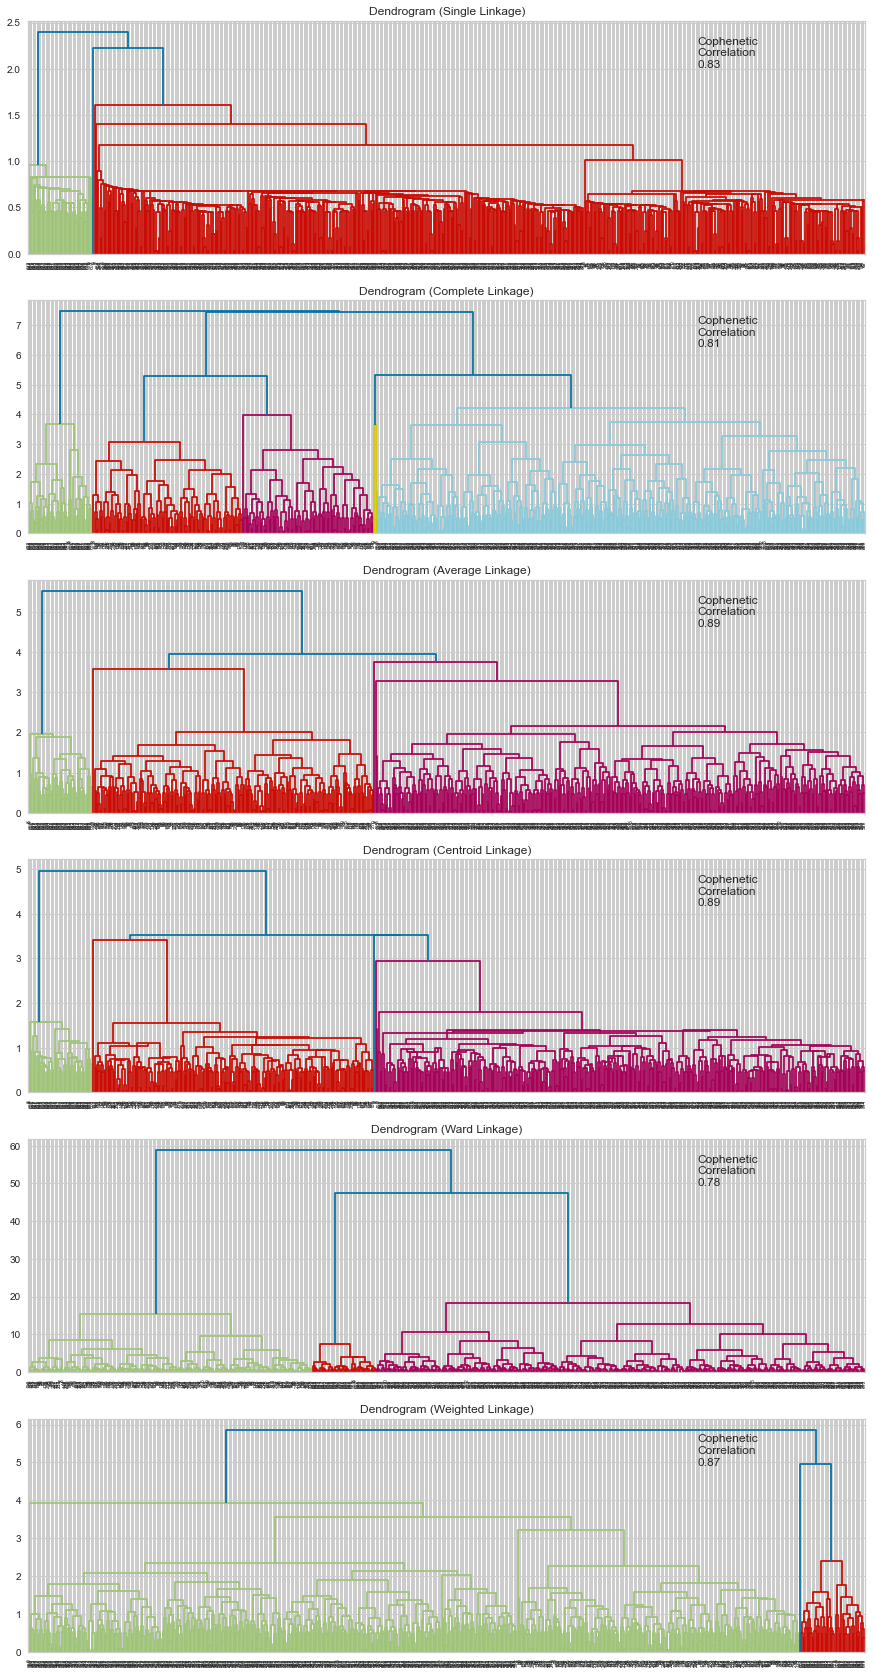

<IPython.core.display.Javascript object>

In [ ]:
# Creating function to develop dendograms based on Euclidian distance and varied linkages
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average and centroid linkage methods
- I will use average linkage which yielded the highest cophenetic linkage
- 3 looks to be an  appropriate number of clusters from the dendrogram for average linkage
- When I look at 4 or 5 clusters, the 4th and 5th cluster contain only a small number of observations that are outliers
  to the larger clusters

In [ ]:
#  fitting to the euclidian, average linkage with 3 clusters
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [ ]:
# copying df into a new dataframe and dropping the segmentation from kmeans clustering
df1 = df.copy()
df1.drop("K_means_segments", axis=1, inplace=True)
df1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_contacts
0,100000,2,1,1.0,0,2.0
1,50000,3,0,8.5,9,18.5
2,50000,7,1,3.0,4,8.0
3,30000,5,1,1.0,4,6.0
4,100000,6,0,8.5,3,15.0


<IPython.core.display.Javascript object>

In [ ]:
# creating a segmentation column and adding to the df1 dataframe
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df1["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

## Creating Heirarchical CLuster Profiles

In [ ]:
cluster_profile = df1.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [ ]:
cluster_profile["count_in_each_segments"] = (
    df1.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [ ]:
# displaying cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_contacts,count_in_each_segments
HC_Clusters,,,,,,,
0,33874.015748,5.498688,3.461942,0.986877,1.994751,6.443570,381
1,103440.000000,8.740000,0.600000,8.180000,1.080000,12.580000,50
2,12284.403670,2.403670,0.949541,3.580275,6.954128,11.488532,218


<IPython.core.display.Javascript object>

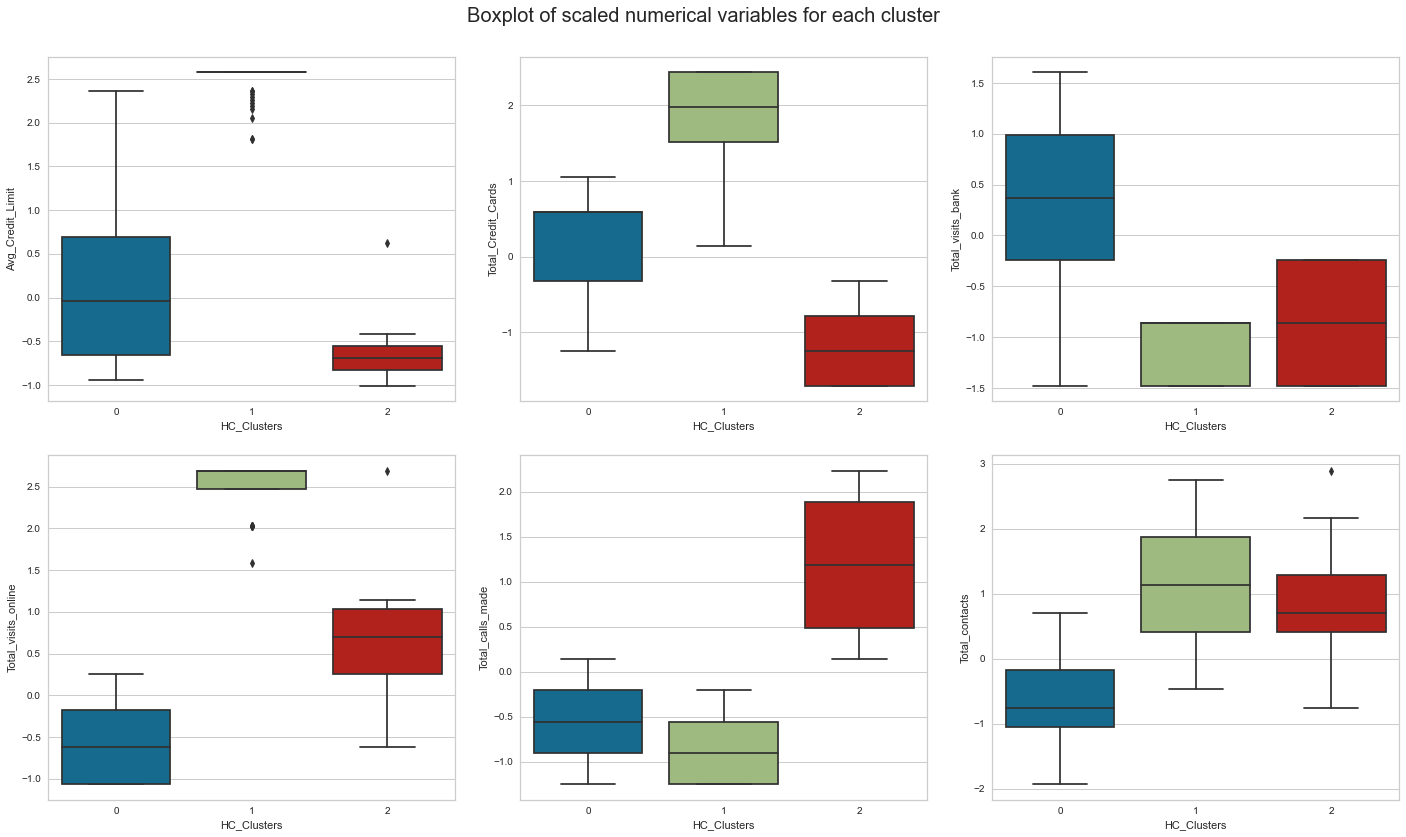

<IPython.core.display.Javascript object>

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(2):
    sns.boxplot(
        ax=axes[ii][0],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)

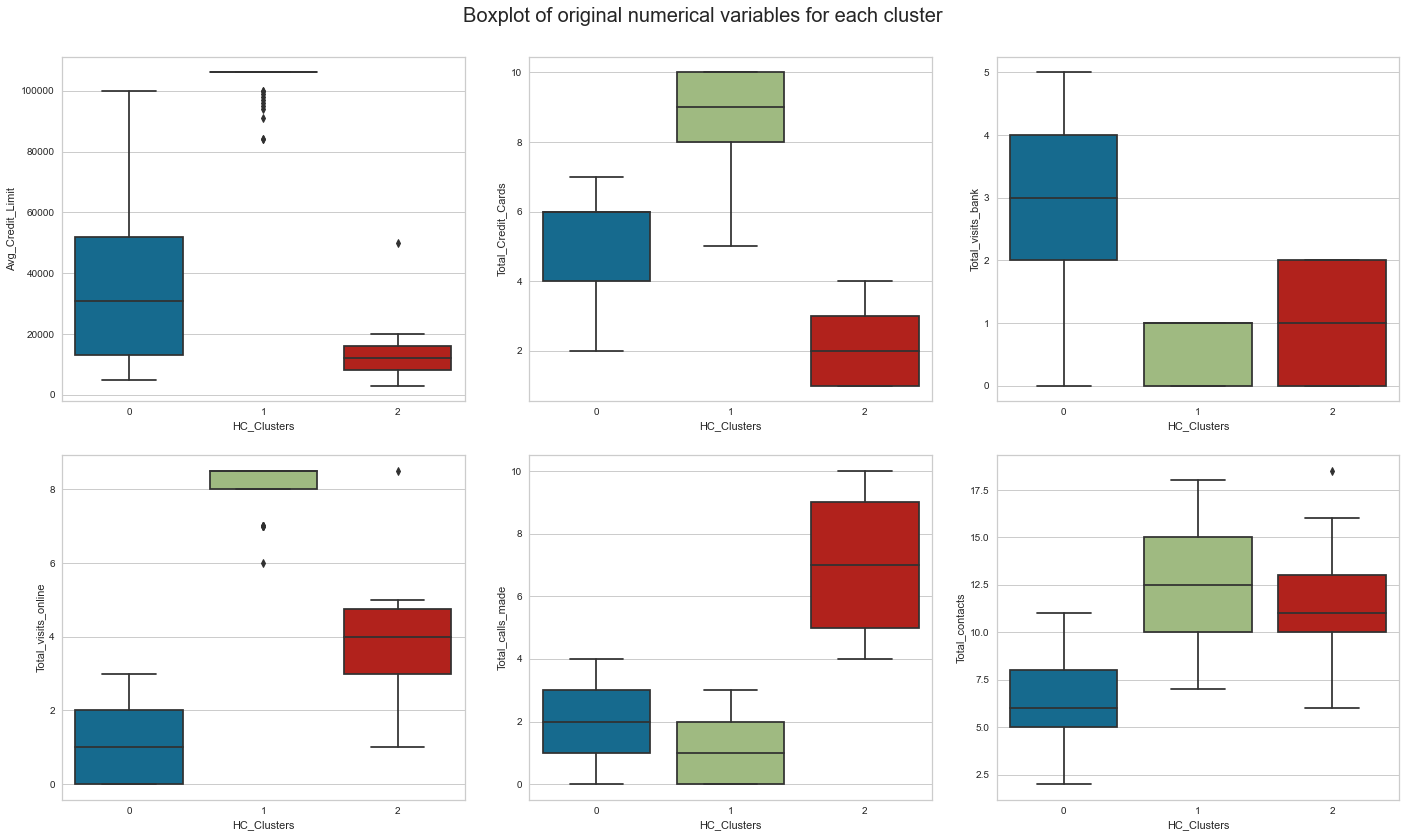

<IPython.core.display.Javascript object>

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(2):
    sns.boxplot(ax=axes[ii][0], y=df1[num_col[counter]], x=df1["HC_Clusters"])
    counter = counter + 1
    sns.boxplot(ax=axes[ii][1], y=df1[num_col[counter]], x=df1["HC_Clusters"])
    counter = counter + 1
    sns.boxplot(ax=axes[ii][2], y=df1[num_col[counter]], x=df1["HC_Clusters"])
    counter = counter + 1


fig.tight_layout(pad=2.0)

Observations  Note:
- **Cluster 2**:
  - Low average credit limits, nearly all below 20,000
  - Few cards held, on average 2 cards but no more than 4
  - Calls the bank often. on average 7 times and also uses online moderately
  - Contacts the bank on average 11 times , primarily by phone
- **Cluster 0**:
  - Moderate credit limits, the average is above 30,000 but ranges up to 100,000
  - They visit the bank most often, 75% visit at least 3 times.  On avaerage they only use online once and call twice
  - Contacts the bank least frequently, half as frequently as other customers, on average 6 times
- **Cluster 1**:
  - High average credit limits, None below 80,000
  - 5 to 10 credit cards
  - Frequently make online contact, 6 to 9 contacts per customer
  - Contacts the bank most frequently with a quarter of the group contacting 15 times
  

## Comparing KMeans and Heirarchical Clustering

In [ ]:
# displaying KMeans cluster profiles
cluster_profile_Kmeans.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_contacts,count_in_each_segments
K_means_segments,,,,,,,
0,12251.141553,2.401826,0.945205,3.573059,6.931507,11.454338,219
1,33950.000000,5.507895,3.471053,0.984211,1.994737,6.450000,380
2,103440.000000,8.740000,0.600000,8.180000,1.080000,12.580000,50


<IPython.core.display.Javascript object>

In [ ]:
# displaying heirarchical cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_contacts,count_in_each_segments
HC_Clusters,,,,,,,
0,33874.015748,5.498688,3.461942,0.986877,1.994751,6.443570,381
1,103440.000000,8.740000,0.600000,8.180000,1.080000,12.580000,50
2,12284.403670,2.403670,0.949541,3.580275,6.954128,11.488532,218


<IPython.core.display.Javascript object>

**Observations**
- Reviewing the cluster profiles above, the clusters were labeled differently but the clusters are almost identical.
- Both techiniques used 3 clusters and the only difference was that one observation moved from one cluster to another
-  That being the case, my profile observations were the same using both techniques

- **Cluster with Low average credit limits**:
  - Low average credit limits, nearly all below 20,000
  - Few cards held, on average 2 cards but no more than 4
  - Calls the bank often. on average 7 times and also uses online moderately
  - Contacts the bank on average 11 times , primarily by phone
- **Cluster with High moderate credit limits**:
  - Moderate credit limits, the average is above 30,000 but ranges up to 100,000
  - They visit the bank most often, 75% visit at least 3 times.  On avaerage they only use online once and call twice
  - Contacts the bank least frequently, half as frequently as other customers, on average 6 times
- **Cluster with High average credit limits**:
  - High average credit limits, None below 80,000
  - 5 to 10 credit cards
  - Frequently make online contact, 6 to 9 contacts per customer
  - Contacts the bank most frequently with a quarter of the group contacting 15 times
  

## PCA
Note that this project rubric does not require PCA due to the low dimensionality.  I am going to go ahead and perform
PCA so that i get the experience and can see the impact

In [ ]:
# creating a new dataframe
subset_scaled_df2 = subset_scaled_df.drop("HC_Clusters", axis=1).copy()

<IPython.core.display.Javascript object>

In [ ]:
# fitting to PCA
pca = PCA()
pca.fit(subset_scaled_df2)

PCA()

<IPython.core.display.Javascript object>

In [ ]:
# getting the variance contribution ratios
pca.explained_variance_ratio_

array([0.48253223, 0.31844785, 0.09747834, 0.04869841, 0.04378724,
       0.00667182, 0.0023841 ])

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Cumulative Explained Variance')

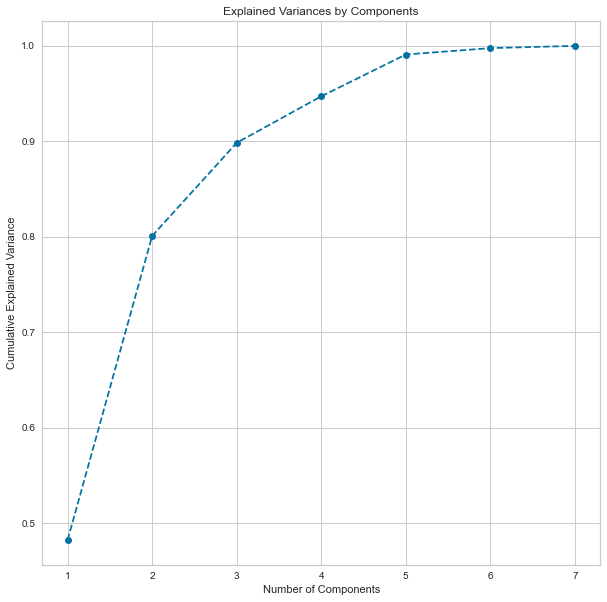

<IPython.core.display.Javascript object>

In [ ]:
# visualizing the variance explained by individual principal components
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 8), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

**Five components explain ~99% of the variance.  The remaining 2 add little to variance explanation**

In [ ]:
# fitting to the 5 components
pca = PCA(
    5, svd_solver="full"
)  # svd_solver=full helps in faster convergence in case of very large data set
pca.fit(subset_scaled_df2)

PCA(n_components=5, svd_solver='full')

<IPython.core.display.Javascript object>

In [ ]:
# checking the variance explained by individual components.
pca.explained_variance_ratio_

array([0.48253223, 0.31844785, 0.09747834, 0.04869841, 0.04378724])

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Cumulative Explained Variance')

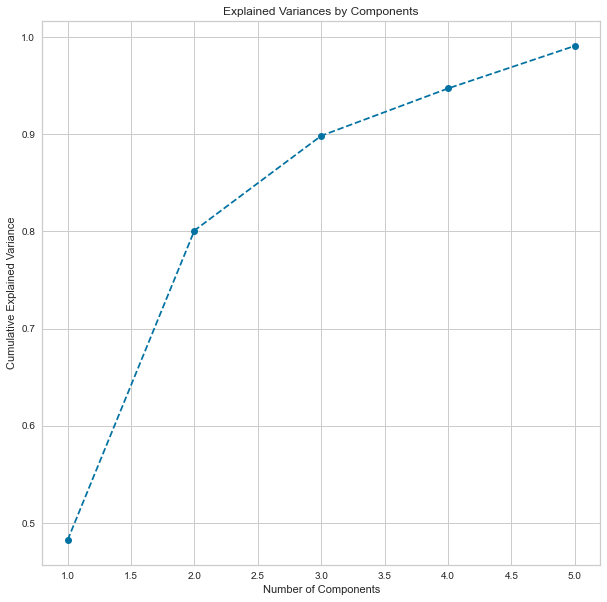

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 6), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [ ]:
subset_pca = pca.transform(subset_scaled_df2)
subset_pca_df = pd.DataFrame(subset_pca)

<IPython.core.display.Javascript object>

## Hierarchical Clustering on lower-dimensional data

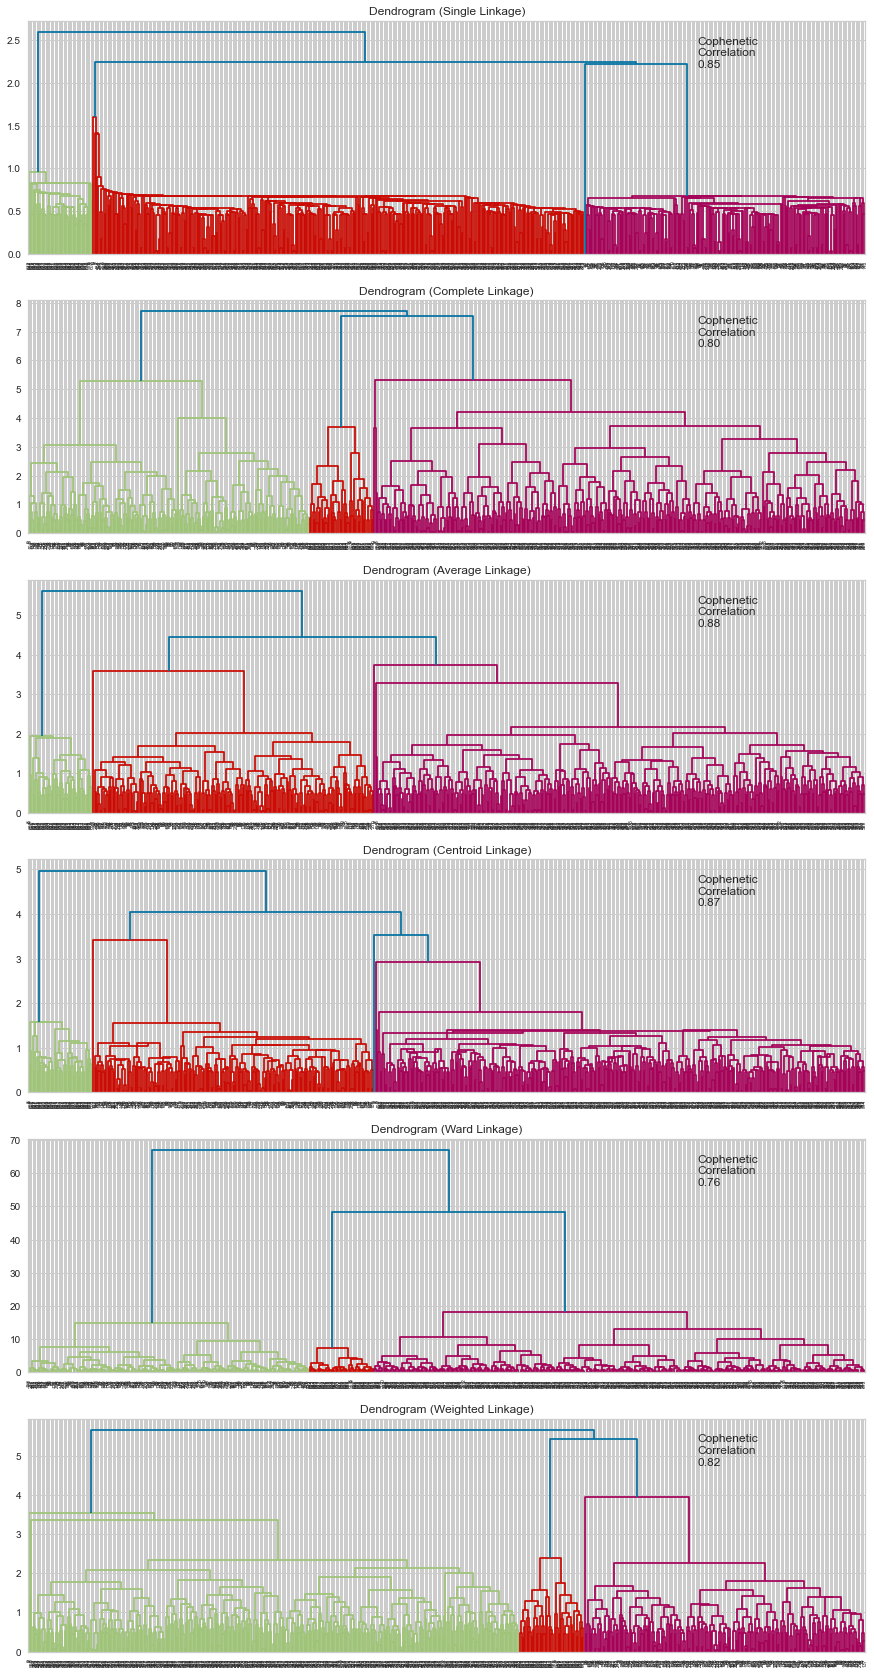

<IPython.core.display.Javascript object>

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_pca_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**
- The average linkage again provides the highest cophenetic correlation which is at .88, slightly lower than before PCA (.89)
- still using 3 clusters

In [ ]:
# performing the heirarchical clustering to the post-PCA data
hc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
hc_labels = hc.fit_predict(subset_pca)

<IPython.core.display.Javascript object>

In [ ]:
# adding hierarchical cluster labels to the original dataframe
df2 = df1.drop(["HC_Clusters"], axis=1)
df2["PCA_HC_Clusters"] = hc_labels

<IPython.core.display.Javascript object>

## Post PCA Cluster Profiling

In [ ]:
cluster_profile2 = df2.groupby("PCA_HC_Clusters").mean()
cluster_profile2["count_in_each_segments"] = (
    df2.groupby("PCA_HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [ ]:
# let's display cluster profile
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_contacts,count_in_each_segments
PCA_HC_Clusters,,,,,,,
0,33874.015748,5.498688,3.461942,0.986877,1.994751,6.443570,381
1,103440.000000,8.740000,0.600000,8.180000,1.080000,12.580000,50
2,12284.403670,2.403670,0.949541,3.580275,6.954128,11.488532,218


<IPython.core.display.Javascript object>

**Observations**
- The PCA Heirchaical clusters are identical to the pre-PCA clusters.  
- This PCA exercise demonstrated that I could use PCA to reduce the dimensions and still get comparable (in this case, exact)
  results.
- However, the PCA was not needed as the dimensions were so small the effect on compute time was minimal
- Since the clusters were the same there is no need to repeat the profiling process further

# Key Business Takeaways

- Credit card customers can be segmented into 3 segments

- A Segment of customers with higher credit limits, a larger number of credit cards and a propensity to
  contact the bank often, primarily online.  This segment holds five or more cards and average credit limit above 80,000.
  This is the smallest segment, but should be very profitable.

- A segment of customers with moderate credit limits who visit the bank least often, but when they do, it is primarily an
  in person visit to the bank.  Their avearage credit limit ranges from 30,000 to 100,000.  This is the largest segment.

- A segment of customers with low avereage credit limits (below 20,000) and few cards. They contact the bank fairly often,
  primarily by phone.

 # Business Recommendations

**Upselling Goal**
1.  Target the moderate customer for higher credit limits and additional cards.  As they are visiting the bank more often,
    provide splashy literature on premium cards and cards with affinity programs with hotel, car rental and airlines.
2.  Target the small base of high limit customers with in bank account executives.  Encourage a quarterly in bank appoitnment
    where additional services are highlighted
3.  As the low limit group is large and likes to call, train and provide incentives to the call center reps to upsell products.

**Improved Customer Service**
1.  Provide a program to oartner with a PC or tablet provide for discounted product targeting the moderate credit limit segment
    to increase online use.  The goal is to increase online visits for efficiency but be careful not to eliminate the personal
    touch for those who prefer that.
2.  Invest in better trained call center personel with both upselling skills and customer service skills.